In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.io import loadmat

from aux import loadmat_h5, get_seg, get_outliers, mv_avg
from disp import set_plot, plot_b

T_MAX = 360
T = np.arange(T_MAX)
NROI = 20

T_SINE = np.array([5, 25, 45])
T_PULSE = np.array([65, 85, 105])
T_NAT = np.array([125, 195, 265])

SMOOTH = 3

# EXPT = '220718_stim_2'
EXPT = '220718_stim_3'
# EXPT = '220718_stim_6'
# EXPT = '220805_stim_1'
# EXPT = '220805_stim_2'
DATA_DIR = f'data/original/lin_20220805/nat_song_imaging/{EXPT}/supervoxels/'
FNAME_STIM = 'data/original/lin_20220805/nat_song_imaging/blocks_plus3songs_forplotting.mat'

In [2]:
stims = loadmat(FNAME_STIM)
stim_pulse = stims['pulse_song'].flatten()
stim_sine = stims['sine_song'].flatten()
tstim = stims['stim_time'].flatten()

mtstim_nat_0 = ((T_NAT[0] - 5) <= tstim) & (tstim < T_NAT[0] + 65)

stim = np.zeros(len(tstim), dtype=int)
stim[stim_sine > 0] = 1
stim[stim_pulse > 0] = 2

In [3]:
rsps_s_all = []
rsps_p_all = []
rsps_n_all = []

t_pre = -5
t_post = 15
t_block = np.arange(t_pre, t_post)

t_post_nat = 65
t_nat = np.arange(t_pre, t_post_nat)

for SLICE in range(0, 9):
    FNAME = f'{EXPT}_n20_t360_slice{SLICE}.h5'
    z_dff = loadmat_h5(os.path.join(DATA_DIR, FNAME))['z_dff']

    dffs = []

    for dff in z_dff.T:

        dff[get_outliers(dff, 3)] = np.nan
        dff_smooth = mv_avg(T, dff, SMOOTH)
        
        # z-score
        dff_smooth -= np.nanmean(dff_smooth)
        dff_smooth /= np.nanstd(dff_smooth)

        dffs.append(dff_smooth)

    # get song-onset-triggered neural responses
    for croi, dff in enumerate(dffs):
        
        # sine
        rsps_s = []

        for t_ in T_SINE:
            mt = ((t_ + t_pre) <= T) & (T < (t_ + t_post))
            rsp_s = dff[mt] - np.nanmean(dff[mt][t_block < 0])
            rsps_s.append(rsp_s)
            
        rsps_s_all.append(np.array(rsps_s))

        # pulse 
        rsps_p = []

        for t_ in T_PULSE:
            mt = ((t_ + t_pre) <= T) & (T < (t_ + t_post))
            rsp_p = dff[mt] - np.nanmean(dff[mt][t_block < 0])
            rsps_p.append(rsp_p)
        
        rsps_p_all.append(np.array(rsps_p))

        # natural song 
        rsps_n = []

        for t_ in T_NAT:
            mt = ((t_ + t_pre) <= T) & (T < (t_ + t_post_nat))
            rsp_n = dff[mt] - np.nanmean(dff[mt][t_nat < 0])
            rsps_n.append(rsp_n)

        rsps_n_all.append(np.array(rsps_n))

In [4]:
stds_s = np.array([np.nanstd(rsps_s, axis=0)[0 <= t_block] for rsps_s in rsps_s_all])
stds_p = np.array([np.nanstd(rsps_p, axis=0)[0 <= t_block] for rsps_p in rsps_p_all])
stds_n = np.array([np.nanstd(rsps_n, axis=0)[0 <= t_nat] for rsps_n in rsps_n_all])

stds_s_mn = np.mean(stds_s, axis=1)
stds_p_mn = np.mean(stds_p, axis=1)
stds_n_mn = np.mean(stds_n, axis=1)

# block song mean stds
stds_blk_mn = np.mean(np.concatenate([stds_s, stds_p], axis=1), axis=1)

0.8873024181942033
0.7402551603033527
0.9221953060046909
1.4659997831185477e-07


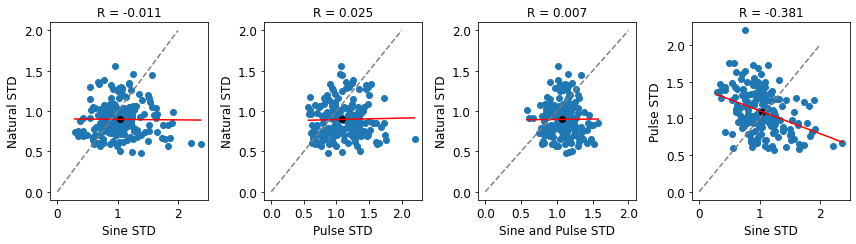

In [5]:
from disp import get_line

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), tight_layout=True)
axs[0].scatter(stds_s_mn, stds_n_mn)
x_line, y_line, (slp, icpt, r, p, std_err) = get_line(stds_s_mn, stds_n_mn)
axs[0].plot(x_line, y_line, c='r')
print(p)
axs[0].scatter(np.nanmean(stds_s_mn), np.nanmean(stds_n_mn), c='k')
set_plot(axs[0], x_label='Sine STD', y_label='Natural STD', title=f'R = {r:.3f}', font_size=12)

axs[1].scatter(stds_p_mn, stds_n_mn)
x_line, y_line, (slp, icpt, r, p, std_err) = get_line(stds_p_mn, stds_n_mn)
axs[1].plot(x_line, y_line, c='r')
print(p)
axs[1].scatter(np.nanmean(stds_p_mn), np.nanmean(stds_n_mn), c='k')
set_plot(axs[1], x_label='Pulse STD', y_label='Natural STD', title=f'R = {r:.3f}', font_size=12)

axs[2].scatter(stds_blk_mn, stds_n_mn)
x_line, y_line, (slp, icpt, r, p, std_err) = get_line(stds_blk_mn, stds_n_mn)
axs[2].plot(x_line, y_line, c='r')
print(p)
axs[2].scatter(np.nanmean(stds_blk_mn), np.nanmean(stds_n_mn), c='k')
set_plot(axs[2], x_label='Sine and Pulse STD', y_label='Natural STD', title=f'R = {r:.3f}', font_size=12)

axs[3].scatter(stds_s_mn, stds_p_mn)
x_line, y_line, (slp, icpt, r, p, std_err) = get_line(stds_s_mn, stds_p_mn)
axs[3].plot(x_line, y_line, c='r')
print(p)
axs[3].scatter(np.nanmean(stds_s_mn), np.nanmean(stds_p_mn), c='k')
set_plot(axs[3], x_label='Sine STD', y_label='Pulse STD', title=f'R = {r:.3f}', font_size=12)

for ax in axs:
    ax.plot([0, 2], [0, 2], ls='--', color='gray')

## Measure response variation across repetitions of same vs different song segments